<a href="https://colab.research.google.com/github/Lasrixx/BookRecommendationEngine/blob/main/fcc_book_recommendation_knn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will create a book recommendation algorithm using **K-Nearest Neighbors**.

You will use the [Book-Crossings dataset](http://www2.informatik.uni-freiburg.de/~cziegler/BX/). This dataset contains 1.1 million ratings (scale of 1-10) of 270,000 books by 90,000 users. 

After importing and cleaning the data, use `NearestNeighbors` from `sklearn.neighbors` to develop a model that shows books that are similar to a given book. The Nearest Neighbors algorithm measures distance to determine the “closeness” of instances.

Create a function named `get_recommends` that takes a book title (from the dataset) as an argument and returns a list of 5 similar books with their distances from the book argument.

This code:

`get_recommends("The Queen of the Damned (Vampire Chronicles (Paperback))")`

should return:

```
[
  'The Queen of the Damned (Vampire Chronicles (Paperback))',
  [
    ['Catch 22', 0.793983519077301], 
    ['The Witching Hour (Lives of the Mayfair Witches)', 0.7448656558990479], 
    ['Interview with the Vampire', 0.7345068454742432],
    ['The Tale of the Body Thief (Vampire Chronicles (Paperback))', 0.5376338362693787],
    ['The Vampire Lestat (Vampire Chronicles, Book II)', 0.5178412199020386]
  ]
]
```

Notice that the data returned from `get_recommends()` is a list. The first element in the list is the book title passed in to the function. The second element in the list is a list of five more lists. Each of the five lists contains a recommended book and the distance from the recommended book to the book passed in to the function.

If you graph the dataset (optional), you will notice that most books are not rated frequently. To ensure statistical significance, remove from the dataset users with less than 200 ratings and books with less than 100 ratings.

The first three cells import libraries you may need and the data to use. The final cell is for testing. Write all your code in between those cells.

In [ ]:
# import libraries (you may add additional imports but you may not have to)
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt

In [ ]:
# get data files
!wget https://cdn.freecodecamp.org/project-data/books/book-crossings.zip

!unzip book-crossings.zip

books_filename = 'BX-Books.csv'
ratings_filename = 'BX-Book-Ratings.csv'

--2022-08-14 10:29:45--  https://cdn.freecodecamp.org/project-data/books/book-crossings.zip
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.3.33, 172.67.70.149, 104.26.2.33, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.3.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 26085508 (25M) [application/zip]
Saving to: ‘book-crossings.zip’

book-crossings.zip  100%[===================>]  24.88M  5.05MB/s    in 12s     

2022-08-14 10:29:58 (1.99 MB/s) - ‘book-crossings.zip’ saved [26085508/26085508]

Archive:  book-crossings.zip
  inflating: BX-Book-Ratings.csv     
  inflating: BX-Books.csv            
  inflating: BX-Users.csv            


In [ ]:
# import csv data into dataframes
df_books = pd.read_csv(
    books_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['isbn', 'title', 'author'],
    usecols=['isbn', 'title', 'author'],
    dtype={'isbn': 'str', 'title': 'str', 'author': 'str'})

df_ratings = pd.read_csv(
    ratings_filename,
    encoding = "ISO-8859-1",
    sep=";",
    header=0,
    names=['user', 'isbn', 'rating'],
    usecols=['user', 'isbn', 'rating'],
    dtype={'user': 'int32', 'isbn': 'str', 'rating': 'float32'})

In [ ]:
df_books.head()

,isbn,title,author
0,0195153448,Classical Mythology,Mark P. O. Morford
1,0002005018,Clara Callan,Richard Bruce Wright
2,0060973129,Decision in Normandy,Carlo D'Este
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata
4,0393045218,The Mummies of Urumchi,E. J. W. Barber


In [ ]:
df_ratings.head()

,user,isbn,rating
0,276725,034545104X,0.0
1,276726,0155061224,5.0
2,276727,0446520802,0.0
3,276729,052165615X,3.0
4,276729,0521795028,6.0


In [ ]:
df_books.shape

(271379, 3)

In [ ]:
df_ratings.shape

(1149780, 3)

In [ ]:
df_books.dropna(inplace=True)

In [ ]:
# Merge the 2 dataframes - just like databases this will make it easier to access the data we need
# The primary key of the df will be title and user
df = df_ratings.merge(df_books, how='left', on='isbn')
df.head()

,user,isbn,rating,title,author
0,276725,034545104X,0.0,Flesh Tones: A Novel,M. J. Rose
1,276726,0155061224,5.0,Rites of Passage,Judith Rae
2,276727,0446520802,0.0,The Notebook,Nicholas Sparks
3,276729,052165615X,3.0,Help!: Level 1,Philip Prowse
4,276729,0521795028,6.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather


In [ ]:
df.shape

(1149780, 5)

In [ ]:
# To prove the point of statistical significance, we will plot the amount of ratings a book has against its average rating
def plot(): 
  freqs = df.title.value_counts()
  ratings = df.groupby(by=['title']).agg({'rating':np.mean})

  plt.scatter(freqs,ratings)
  plt.show()

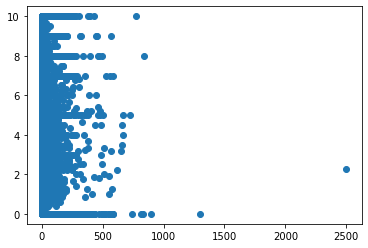

In [ ]:
# This is the dataset with statistically insignificant still included
plot()

In [ ]:
# Need to do a little bit of clean up on the data
# Need to remove books with less than 100 ratings and users with less than 200 ratings
user_count = df.user.value_counts()
#print(user_count)
book_count = df.isbn.value_counts()
#print(book_count)

# Remove insignificant users
df = df[
  ~df['user'].isin(user_count[user_count < 200].index)
]
print(df.shape)

# Remove insignificant books
df = df[
  ~df['isbn'].isin(book_count[book_count < 100].index)
]
print(df.shape)

#df.head()

(527556, 5)
(49781, 5)


In [ ]:
df.head()

,user,isbn,rating,title,author
1456,277427,002542730X,10.0,Politically Correct Bedtime Stories: Modern Ta...,James Finn Garner
1469,277427,0060930535,0.0,The Poisonwood Bible: A Novel,Barbara Kingsolver
1471,277427,0060934417,0.0,Bel Canto: A Novel,Ann Patchett
1474,277427,0061009059,9.0,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich
1484,277427,0140067477,0.0,The Tao of Pooh,Benjamin Hoff


In [ ]:
# Convert data into matrix for the NearestNeighbour model
df_pivot = df.pivot_table(index=['user'],columns=['title'],values='rating').fillna(0).T
df_pivot.head()

user,254,2276,2766,2977,3363,4017,4385,6242,6251,6323,...,274004,274061,274301,274308,274808,275970,277427,277478,277639,278418
title,,,,,,,,,,,,,,,,,,,,,
1984,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1st to Die: A Novel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2nd Chance,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4 Blondes,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Beautiful Mind: The Life of Mathematical Genius and Nobel Laureate John Nash,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Create the model
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(df_pivot.values)

NearestNeighbors(algorithm='brute', metric='cosine')

In [ ]:
# Little bit of testing
title = '1st to Die: A Novel'

print(df_pivot.iloc[0].shape)
print(df_pivot.loc[title].shape)

distance, indice = model.kneighbors([df_pivot.loc[title].values], n_neighbors=6)

print(distance)
print(indice)

(888,)
(888,)
[[1.1920929e-07 7.0633805e-01 7.0653141e-01 7.1565664e-01 7.2228849e-01
  7.3945004e-01]]
[[  1 405  42 643 374 331]]


In [ ]:
# function to return recommended books - this will be tested
def get_recommends(book = ""):

  node = df_pivot[df_pivot.index == book]
  node = node.to_numpy().reshape(1,-1)

  #node = df_pivot.loc[book]

  # Use model to find nearest neighbors
  distances, indices = model.kneighbors(node, n_neighbors=6)

  # Turn distances and indices into output
  recommended_books = []
  # Distances come in ascending order but test case look for distances in descending so just look through array other way
  for i in range(len(distances.flatten())-1,0,-1):
    recommended_books.append([df_pivot.iloc[indices.flatten()[i]].name,distances.flatten()[i]])

  return [book,recommended_books]

In [ ]:
books = get_recommends('1st to Die: A Novel')
print(books)

['1st to Die: A Novel', [['Silent Night : A Christmas Suspense Story', 0.70633805], ['Along Came a Spider (Alex Cross Novels)', 0.7065314], ['Violets Are Blue', 0.71565664], ['Roses Are Red (Alex Cross Novels)', 0.7222885], ['On the Street Where You Live', 0.73945004]]]


Use the cell below to test your function. The `test_book_recommendation()` function will inform you if you passed the challenge or need to keep trying.

In [ ]:
books = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
print(books)

def test_book_recommendation():
  test_pass = True
  recommends = get_recommends("Where the Heart Is (Oprah's Book Club (Paperback))")
  if recommends[0] != "Where the Heart Is (Oprah's Book Club (Paperback))":
    test_pass = False
  recommended_books = ["I'll Be Seeing You", 'The Weight of Water', 'The Surgeon', 'I Know This Much Is True']
  recommended_books_dist = [0.8, 0.77, 0.77, 0.77]
  for i in range(2): 
    if recommends[1][i][0] not in recommended_books:
      test_pass = False
    if abs(recommends[1][i][1] - recommended_books_dist[i]) >= 0.05:
      test_pass = False
  if test_pass:
    print("You passed the challenge! 🎉🎉🎉🎉🎉")
  else:
    print("You haven't passed yet. Keep trying!")

test_book_recommendation()

["Where the Heart Is (Oprah's Book Club (Paperback))", [["I'll Be Seeing You", 0.8016211], ['The Weight of Water', 0.77085835], ['The Surgeon', 0.7699411], ['I Know This Much Is True', 0.7677075], ['The Lovely Bones: A Novel', 0.7234864]]]
You passed the challenge! 🎉🎉🎉🎉🎉
